In [ ]:
from brainiak.isc import isc,bootstrap_isc,compute_summary_statistic,isfc,squareform_isfc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
def r2numpy(rvec):
    
    return np.array(rvec[2:-1].split(', '),dtype = 'float')

# def trim_movielength(dataf):
    
#     trimmed = dataf['tc_mean_unfolded'][:movie_length[dataf['muvi']]]
    
#     return trimmed
    
    
def stdize(a):
    
    return (a - np.average(a)) / np.std(a)



In [ ]:
froot = '/data00/layerfMRI/'
datafld = froot + 'Github_repo/layerfMRI/analyses/dual_ISC/TC_4_lorenzo/'
os.listdir(datafld)

In [ ]:
logsumm = (pd
           .read_csv(froot+ 'logs/log_summary.csv')
           .assign(fmri = lambda d:
                   froot + 
                   'regdata/sub_' + d['subject'].apply(lambda n: '{:02d}'.format(n)) +
                   '/ses_' + d['session'].apply(lambda n: '{:02d}'.format(n)) +
                   '/func/task_' + d['task'].apply(lambda n: '{:01d}'.format(n)) +
                   '_run_' + d['run'].apply(lambda n: '{:01d}'.format(n)) +
                   '_4D_MNI.nii.gz'
                  )
           .assign(fmri_missing = lambda d : d['fmri'].apply(lambda s: os.path.isfile(s) != True))
           
          )


movie_length = {}

for mv in logsumm.Title.unique():
    durations = logsumm.loc[lambda d : d['Title'] == mv].ExpectedDuration.unique()
    if len(durations) != 1:
        print('Warning! More than one duration found')
        movie_length[mv] = np.min(durations)
    else:
        movie_length[mv] = durations[0]



In [452]:
nbins = 6
thr = 200
method = 'M_OR_S'

In [453]:
f = f'{method}_JU_time_courses_thr{thr}_bin{nbins}.csv'

# Read dataframe
df = pd.read_csv(datafld + f)

# Transform timecourses into numpy arrays and standardize them
df['tc_mean_unfolded'] = (df['tc_mean_unfolded']
                          .map(r2numpy)
                         )

# Correct for movies that are missing the last frame
df['measured_movl'] = df.apply(lambda row : len(row['tc_mean_unfolded']), axis = 1)
df['expected_movl'] = df.apply(lambda row : movie_length[row['muvi']], axis = 1)

corrected_movl = (df
                  .loc[lambda d : d['expected_movl'] > d['measured_movl']]
                  .groupby('muvi')
                  .apply(lambda d: np.min(d['measured_movl']))
                 )

for m in dict(corrected_movl):
    movie_length[m] = corrected_movl[m]
#####################################################

df['tc_mean_trimmed'] = (df
                         .apply(lambda row : row['tc_mean_unfolded'][:movie_length[row['muvi']]], axis = 1)
                         .map(stdize)
                        )

df['measured_movl'] = df.apply(lambda row : len(row['tc_mean_trimmed']), axis = 1)

# Get movie names
movie_names = {}
for c,gdf in df.groupby(['contrast']):
    movie_names[c] = gdf.sort_values(['muvi']).muvi.unique()

# Concatenate movie and task
cdf  = pd.DataFrame()
count = 0

for [c,s,j,d],gdf in df.groupby(['contrast','sub','JU','D_bins']):

    gdf = gdf.sort_values(['muvi','run'])
    movie_list = gdf['muvi'].unique()

    try:
        same = (movie_names[c] == movie_list).all()
    except:
        same = False
    if not same:
        print(f'Error! contrast {c} subject {s} JU {j} D_bins {d}')
    else:
        count += 1

    concatenated = np.hstack(gdf['tc_mean_trimmed'])

    temp_df = gdf.iloc[0][['contrast','sub','JU','D_bins']]
    temp_df['tc_concatenated'] = concatenated

    cdf = cdf.append(temp_df)

In [454]:
cdf = cdf.loc[lambda d: d['sub'] != 'sub_11']

In [455]:
## Extra layer of safety

# This checks what length of the concatenated arrays is the most common and delets combinations of JU and Dbins that are different
for c,contrast_df in cdf.groupby('contrast'):

    T = int(contrast_df['tc_concatenated'].apply(lambda d: len(d)).mode())
    unmatching = contrast_df.loc[contrast_df['tc_concatenated'].apply(lambda d: len(d)) != T][['D_bins','JU']].drop_duplicates()


    for i,unm in unmatching.iterrows():

        cdf = cdf.drop(cdf.loc[lambda d : (d['contrast'] == c)&(d['JU']==unm['JU'])&(d['D_bins']==unm['D_bins'])].index)

        print('Contrast {}: bin {} of JU {} deleted'.format(c,unm['D_bins'],unm['JU']))


    # This checks what length of the concatenated arrays is the most common and delets combinations of JU and Dbins that are different
    grouped_df = contrast_df.groupby(['D_bins','JU']).apply(lambda d:len(d['sub']))
    N_sub = int(grouped_df.mode())
    grouped_df = grouped_df.reset_index()
    unmatching = grouped_df.loc[lambda d: d[0] != N_sub]

    for i,unm in unmatching.iterrows():

        cdf = cdf.drop(cdf.loc[lambda d : (d['contrast'] == c)&(d['JU']==unm['JU'])&(d['D_bins']==unm['D_bins'])].index)

        print('!!Contrast {}: bin {} of JU {} deleted'.format(c,unm['D_bins'],unm['JU']))

cdf['D_bins'] = cdf['D_bins'].astype(int)
cdf['JU'] = cdf['JU'].astype(int)
cdf = cdf.sort_values(['contrast','sub','JU','D_bins'])

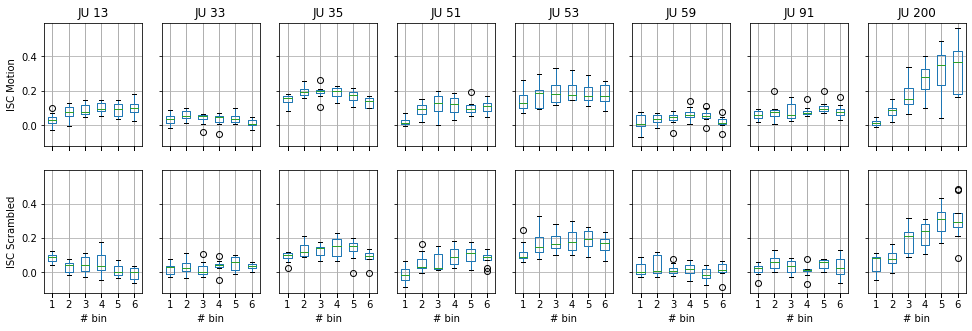

In [456]:
isc_column = np.array([])

for c,contrast_df in cdf.groupby('contrast'):

    iscarr = np.array(list(contrast_df
     .groupby('sub')
     .apply(lambda d: np.array(list(d['tc_concatenated'])).T)
    ))

    iscarr = np.moveaxis(iscarr,0,2)

    isc_data =  isc(iscarr)
    isc_column = np.append(isc_column,isc_data.ravel())

cdf['isc'] = np.arctanh(isc_column)



ncols = cdf['JU'].nunique()
nrows = cdf['contrast'].nunique()

fig,axarr = plt.subplots(ncols=ncols,nrows=nrows, sharex=True, sharey = True, figsize = (ncols*2,5))
axarr = np.ravel(axarr)

for i,((c,j),plotdf) in enumerate(cdf.groupby(['contrast','JU'])):   

    plotdf.boxplot(column = ['isc'], by = 'D_bins',ax=axarr[i])
    axarr[i].set_title('JU {}'.format(int(j)))
    axarr[i].set_ylabel('ISC {}'.format(c))

axarr = axarr.reshape(nrows,ncols)
for ax in axarr[0]:
    ax.set_xlabel('')
for ax in axarr[1]:
    ax.set_xlabel('# bin')
for ax in axarr[:,1:].ravel():
    ax.set_ylabel('')
for ax in axarr[1]:
    ax.set_title('')

fig.suptitle('')
plt.savefig(datafld + f.replace(method,'RESULTS/{}'.format(method)).replace('.csv','_isc.png'), dpi = 300)



cdf.to_csv(datafld + f.replace(method,'RESULTS/{}'.format(method)).replace('.csv','_isc.csv'))

In [457]:
# os.makedirs('/data00/layerfMRI/Github_repo/layerfMRI/analyses/dual_ISC/TC_4_lorenzo/RESULTS/')

In [458]:
cdf

,D_bins,JU,contrast,sub,tc_concatenated,isc
960,1,13,Motion,sub_02,"[-0.857982775442284, 0.3961405928276347, -0.81...",0.097436
961,2,13,Motion,sub_02,"[-0.6121689485606284, -0.41442262115461215, 0....",0.122316
962,3,13,Motion,sub_02,"[-1.254808798792133, 0.7360159510254902, -0.93...",0.112601
963,4,13,Motion,sub_02,"[-1.8145595718289669, 0.9421807083579372, -0.3...",0.131935
964,5,13,Motion,sub_02,"[-1.937179435005998, -0.1234273041502649, 0.93...",0.084087
...,...,...,...,...,...,...
28459,2,200,Scrambled,sub_14,"[1.6908750370992196, 0.5937982667644987, -1.46...",0.168187
28460,3,200,Scrambled,sub_14,"[-1.242141493654162, 1.2462658368241593, -0.43...",0.314468
28461,4,200,Scrambled,sub_14,"[-0.3402723145889234, 0.5793441311038934, 0.57...",0.311683
28462,5,200,Scrambled,sub_14,"[-1.6021269910251628, 0.6919383761750898, 1.12...",0.432154


In [459]:
isc_column = np.array([])

subJUcdf = cdf.loc[lambda d : (d['JU']==13)|(d['JU']==35)|(d['JU']==91)]
subJUcdf = subJUcdf.sort_values(['JU','D_bins'])
isfc_data = {}
isfc_mean_data = {}
nsub = subJUcdf['sub'].nunique()

sel_JUs = {'BA44':13, 'PFt':35, 'BA6':91}

nJU = len(sel_JUs)

for c,contrast_df in subJUcdf.groupby('contrast'):

    iscarr = np.array(list(contrast_df
     .groupby('sub')
     .apply(lambda d: np.array(list(d['tc_concatenated'])).T)
    ))

    iscarr = np.moveaxis(iscarr,0,2)

    isc_data =  isc(iscarr)
    raw_isfc = isfc(iscarr)[0]
    isfc_data[c] = np.zeros((nsub,int(nbins*nJU*(nbins*nJU-1)/2)))
    for r,sub_isfc in enumerate(raw_isfc):
        isfc_data[c][r,:] = np.arctanh(sub_isfc)    
    isfc_mean_data[c] = np.average(isfc_data[c],axis = 0)
    
    
    isc_column = np.append(isc_column,isc_data.ravel())

subJUcdf['isc'] = np.arctanh(isc_column)


In [460]:
nbins*nJU

18

In [461]:
from scipy.spatial.distance import squareform

In [462]:
ttest_1samp(isfc_data['Motion'][:,14],0)

Ttest_1sampResult(statistic=4.418379934178995, pvalue=0.0030873313976701794)

In [463]:
ttest_1samp(isfc_data['Motion'][:,17],0)

Ttest_1sampResult(statistic=5.266282353496269, pvalue=0.0011653329855294073)

In [464]:
from scipy.stats import ttest_1samp,ttest_rel
from statsmodels.stats.multitest import fdrcorrection

In [465]:
squareform(np.average(z,axis=0)*(pmask))

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00480661, -0.00781951,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01887096,  0.        ,  0.03291299,  0.02694918,  0.02430835,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.0279668 ,
         0.03641834,  0.0347332 ,  0.        ,  0

In [474]:
f

'M_OR_S_JU_time_courses_thr200_bin6.csv'

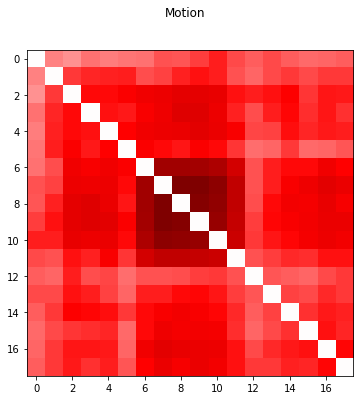

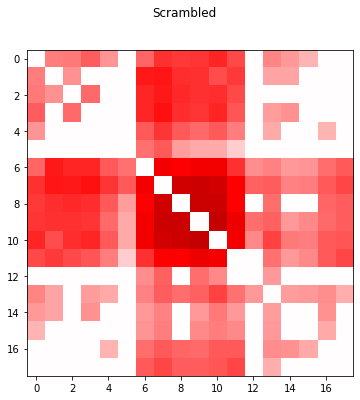

In [484]:


for c in ['Motion','Scrambled']:
    M = 0.2

    fig,axarr = plt.subplots(nrows = 1, ncols=1,#+1, gridspec_kw={'width_ratios':[10]*nJU+[1]})#,
                             sharex=True, sharey=True, figsize = (6,6))


    z = isfc_data[c]
    t,p = ttest_1samp(z, popmean = 0, axis=0)
    pmask, pcorr = fdrcorrection(p,alpha = 0.05, is_sorted=False)

    
    z_matrix = squareform(np.average(z,axis=0)*(pmask))
    cm = axarr.imshow(z_matrix,
                        cmap = 'seismic', vmax=M,vmin=-M)
                
    fout = datafld + 'RESULTS/ISFC_{}_full_thr{}_bin{}.txt'.format(c,thr,nbins)
    np.savetxt(fout,z_matrix)
    
#     plt.colorbar(cm,cax = axarr[1,3])

    
    plt.suptitle(c)


In [487]:
!ls /data00/layerfMRI/Github_repo/layerfMRI/analyses/dual_ISC/TC_4_lorenzo/RESULTS

ISFC_Motion_BA44-BA44_thr200_bin6.txt
ISFC_Motion_BA44-BA6_thr200_bin6.txt
ISFC_Motion_BA44-PFt_thr200_bin6.txt
ISFC_Motion_BA6-BA44_thr200_bin6.txt
ISFC_Motion_BA6-BA6_thr200_bin6.txt
ISFC_Motion_BA6-PFt_thr200_bin6.txt
ISFC_Motion_full_thr200_bin6.txt
ISFC_Motion_PFt-BA44_thr200_bin6.txt
ISFC_Motion_PFt-BA6_thr200_bin6.txt
ISFC_Motion_PFt-PFt_thr200_bin6.txt
ISFC_Scrambled_BA44-BA44_thr200_bin6.txt
ISFC_Scrambled_BA44-BA6_thr200_bin6.txt
ISFC_Scrambled_BA44-PFt_thr200_bin6.txt
ISFC_Scrambled_BA6-BA44_thr200_bin6.txt
ISFC_Scrambled_BA6-BA6_thr200_bin6.txt
ISFC_Scrambled_BA6-PFt_thr200_bin6.txt
ISFC_Scrambled_full_thr200_bin6.txt
ISFC_Scrambled_PFt-BA44_thr200_bin6.txt
ISFC_Scrambled_PFt-BA6_thr200_bin6.txt
ISFC_Scrambled_PFt-PFt_thr200_bin6.txt
M_OR_S_JU_time_courses_thr100_bin10_isc.csv
M_OR_S_JU_time_courses_thr100_bin10_isc.png
M_OR_S_JU_time_courses_thr100_bin6_isc.csv
M_OR_S_JU_time_courses_thr100_bin6_isc.png
M_OR_S_JU_time_courses_thr100_bin8_isc.csv
M_OR_S_JU_time_courses_thr1

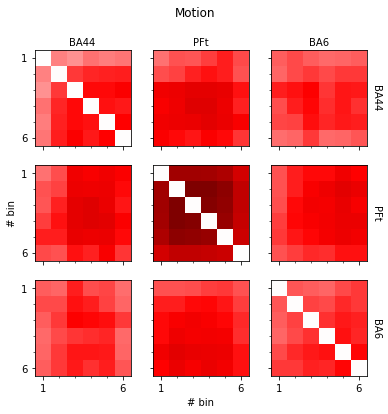

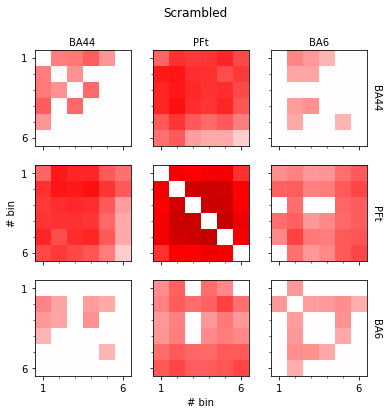

In [486]:
sel_JUs = {'BA44':13, 'PFt':35, 'BA6':91}
list_JUs = list(sel_JUs)

nJU = len(sel_JUs)

for c in isfc_mean_data:
    M = 0.2
    
    
    z = isfc_data[c]
    t,p = ttest_1samp(z, popmean = 0, axis=0)
    pmask, pcorr = fdrcorrection(p,alpha = 0.05)

    

    fig,axarr = plt.subplots(nrows = nJU, ncols=nJU,#+1, gridspec_kw={'width_ratios':[10]*nJU+[1]})#,
                             sharex=True, sharey=True, figsize = (6,6))

    for ix in range(nJU):

        # Labels JU
        axarr[ix,-1].yaxis.set_label_position("right")
        axarr[ix,-1].set_ylabel(list_JUs[ix], rotation = 270, labelpad=14)
        axarr[0,ix].xaxis.set_label_position("top")
        axarr[0,ix].set_xlabel(list_JUs[ix], labelpad=4)
        # Labels bins
        axarr[ix,0].set_yticks(np.arange(0,nbins,5))
        axarr[ix,0].set_yticklabels(np.arange(0,nbins,5)+1)
        axarr[-1,ix].set_xticks(np.arange(0,nbins,5))
        axarr[-1,ix].set_xticklabels(np.arange(0,nbins,5)+1)
        axarr[ix,0].minorticks_on()
        
        for iy in range(nJU):
            

            z_matrix = squareform(np.average(z,axis=0)*(pmask))[nbins*iy:nbins*(iy+1),nbins*ix:nbins*(ix+1)]
            cm = axarr[iy,ix].imshow(z_matrix,
                                cmap = 'seismic', vmax=M,vmin=-M)


            
            fout = datafld + 'RESULTS/ISFC_{}_{}-{}_thr{}_bin{}.txt'.format(c,list_JUs[iy],list_JUs[ix],thr,nbins)
            np.savetxt(fout,z_matrix)

            
#     plt.colorbar(cm,cax = axarr[1,3])
    
    axarr[1,0].set_ylabel('# bin')
    axarr[-1,1].set_xlabel('# bin')
    
    plt.suptitle(c)


In [477]:
os.listdir(datafld+'RESULTS')

['isfc_Motion_PFt-PFt_thr200_bin6.txt',
 'isfc_PFt-BA44_thr200_bin6.txt',
 'isfc_BA44-BA6_thr200_bin6.txt',
 'M_OR_S_JU_time_courses_thr200_bin6_isc.png',
 'M_OR_S_JU_time_courses_thr100_bin6_isc.csv',
 'isfc_BA44-PFt_thr200_bin6.txt',
 'M_OR_S_JU_time_courses_thr100_bin8_isc.png',
 'M_OR_S_JU_time_courses_thr200_bin8_isc.csv',
 'isfc_BA6-BA6_thr200_bin6.txt',
 'isfc_Scrambled_BA44-BA44_thr200_bin6.txt',
 'isfc_Motion_BA44-BA44_thr200_bin6.txt',
 'isfc_Scrambled_PFt-BA6_thr200_bin6.txt',
 'isfc_PFt-PFt_thr200_bin6.txt',
 'M_OR_S_JU_time_courses_thr100_bin6_isc.png',
 'M_OR_S_JU_time_courses_thr100_bin8_isc.csv',
 'isfc_Motion_BA44-BA6_thr200_bin6.txt',
 'isfc_Motion_BA6-BA6_thr200_bin6.txt',
 'M_OR_S_JU_time_courses_thr100_bin10_isc.png',
 'isfc_Scrambled_PFt-PFt_thr200_bin6.txt',
 'isfc_Scrambled_BA6-BA6_thr200_bin6.txt',
 'isfc_Motion_PFt-BA6_thr200_bin6.txt',
 'M_OR_S_JU_time_courses_thr100_bin10_isc.csv',
 'isfc_Motion_PFt-BA44_thr200_bin6.txt',
 'M_OR_S_JU_time_courses_thr200_bin1

Text(0.5, 0.98, 'Motion - Scrambled')

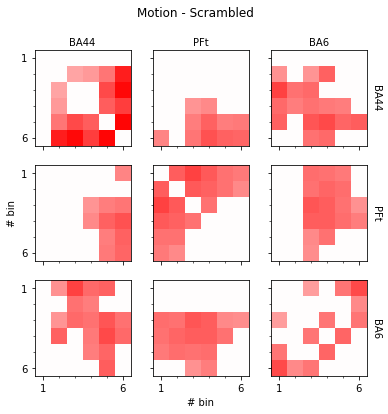

In [468]:
zm = isfc_data['Motion']
zs = isfc_data['Scrambled']

t,p = ttest_rel(zm,zs, axis=0)
pmask, pcorr = fdrcorrection(p,alpha = 0.05)


fig,axarr = plt.subplots(nrows = nJU, ncols=nJU,#+1, gridspec_kw={'width_ratios':[10]*nJU+[1]})#,
                         sharex=True, sharey=True, figsize = (6,6))

for ix in range(nJU):

    # Labels JU
    axarr[ix,-1].yaxis.set_label_position("right")
    axarr[ix,-1].set_ylabel(list(sel_JUs)[ix], rotation = 270, labelpad=14)
    axarr[0,ix].xaxis.set_label_position("top")
    axarr[0,ix].set_xlabel(list(sel_JUs)[ix], labelpad=4)
    # Labels bins
    axarr[ix,0].set_yticks(np.arange(0,nbins,5))
    axarr[ix,0].set_yticklabels(np.arange(0,nbins,5)+1)
    axarr[-1,ix].set_xticks(np.arange(0,nbins,5))
    axarr[-1,ix].set_xticklabels(np.arange(0,nbins,5)+1)
    axarr[ix,0].minorticks_on()
        
    for iy in range(nJU):




        cm = axarr[iy,ix].imshow(squareform(np.average(zm-zs,axis=0)*(pmask))[nbins*iy:nbins*(iy+1),nbins*ix:nbins*(ix+1)],
                            cmap = 'seismic', vmax=M,vmin=-M)


#     plt.colorbar(cm,cax = axarr[1,3])
axarr[1,0].set_ylabel('# bin')
axarr[-1,1].set_xlabel('# bin')
    

plt.suptitle('Motion - Scrambled')


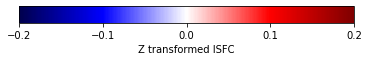

In [469]:
fig,ax = plt.subplots(figsize = (6,0.3))
plt.colorbar(cm,cax = ax,orientation = 'horizontal', ticks = np.arange(-M,M+0.1,0.1))
ax.set_xlabel('Z transformed ISFC')
plt.show()